In [ ]:
# ..... run MN on samples vs Mantri ..... #

In [2]:
library(SingleCellExperiment)
library(MetaNeighbor)
library(Seurat)

In [3]:
# get list of samples
stages = c(rep('stage23', 2), rep(c('stage28', 'stage32'), each = 3))
samples = c('sample3', 'sample10', 'sample5', 'sample10', 'sample11',
           'sample5', 'sample10', 'sample12')

In [4]:
# load list of orthologs
om = read.delim('~/septation/chicken/human_chicken_orthologs_biomart.txt', sep = '\t')
colnames(om) <- c('human', 'chicken', 'LCA', 'homology_type')
om <- om[om[,1]!='' & om[,2]!='' & om$homology_type=='ortholog_one2one',]
dim(om)
om[1,]

[1] 12494     4

human  chicken LCA     homology_type   
6 MT-ND1 ND1     Amniota ortholog_one2one

In [6]:
# load reference data from Mantri et al
sc2 = readRDS('~/septation/markers/Cui/Cui_data.rds')
sc2$dataset = 'Cui'
sc2$celltype = sc2$Cluster

cols = c('dataset', 'celltype')
mtd2 = sc2@meta.data[,cols]

In [7]:
# load data
id = 1
sc1 = readRDS(paste0('~/septation/chicken/', stages[id], '_', samples[id], '_data.rds'))
sc1$dataset = 'Amalia'
sc1$celltype = sc1$seurat_clusters

# get metadata
mtd1 = sc1@meta.data[,cols]
mtd0 = rbind(mtd1, mtd2)

In [ ]:
# get exp data
exp2 = LayerData(sc2, assya = 'RNA', layer = 'counts')
exp1 = LayerData(sc1, assya = 'RNA', layer = 'counts')

In [9]:
# convert to heart-species genes
genes2 = rownames(exp2)
genes2 <- om$chicken[match(genes2, om$human)]

exp3 = exp2[!is.na(genes2),]
genes2 <- genes2[!is.na(genes2)]
rownames(exp3) = genes2

In [12]:
# get commmon gene set
common_genes = intersect(rownames(exp3), rownames(exp1))
common_genes <- common_genes[!is.na(common_genes)]
length(common_genes)

[1] 11621

In [13]:
# make SCE object
sce = SingleCellExperiment(list(counts = cbind(exp1[common_genes,], 
                                               exp3[common_genes,])),
                           colData = DataFrame(mtd0))
sce

class: SingleCellExperiment 
dim: 11621 10113 
metadata(0):
assays(1): counts
rownames(11621): A1CF A4GALT ... ZZEF1 ZZZ3
rowData names(0):
colnames(10113): stage23_sample3_AAACCCAAGTAACAGT-1
  stage23_sample3_AAACCCACAACAGAGC-1 ... HE23W_2_RV.22 HE23W_2_RV.24
colData names(2): dataset celltype
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [14]:
options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$dataset)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

Time difference of 3.529152 secs

[1] 862

In [15]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$dataset, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$dataset, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

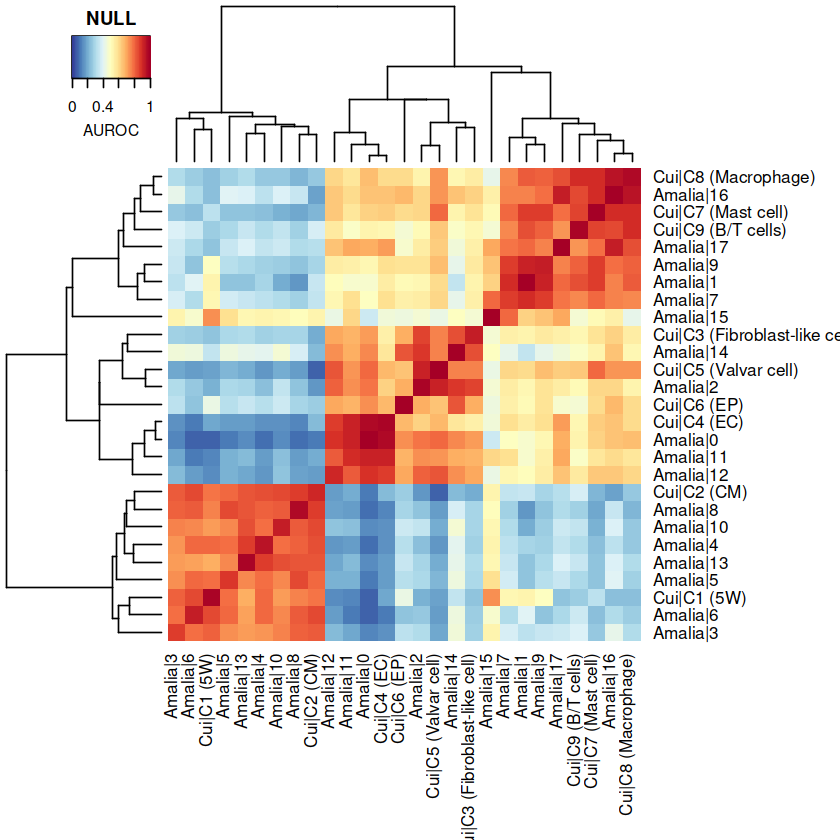

In [16]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
plotHeatmap(aurocsall, margins = c(10,10))
# dev.off()

In [17]:
topHits(aurocsall, dat = sce, study_id = sce$dataset, cell_type = sce$celltype,
        threshold = 0.9)

Study_ID|Celltype_1 Study_ID|Celltype_2  Mean_AUROC Match_type        
1 Amalia|0            Cui|C4 (EC)          0.97       Reciprocal_top_hit
2 Amalia|16           Cui|C8 (Macrophage)  0.96       Reciprocal_top_hit
3 Amalia|2            Cui|C5 (Valvar cell) 0.93       Reciprocal_top_hit
4 Cui|C4 (EC)         Amalia|11            0.92       Above_0.9         
5 Amalia|16           Cui|C7 (Mast cell)   0.90       Above_0.9         
6 Amalia|8            Cui|C2 (CM)          0.87       Reciprocal_top_hit

In [ ]:
# save
# save(aurocsall, aurocs1v1, 
#      file = paste0(stages[id], '_', samples[id], '_Mantri_MN_scores.Rdata'))